In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

# allocating GPU memory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
        )
    except RuntimeError as e:
        print(e)

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tfd = tfp.distributions

# ----------------------------
# Generate synthetic "true" data
# ----------------------------
# True model parameters (used to generate the data)
true_slope = 2.5
true_intercept = 1.0
sigma_obs = 0.5  # observation noise standard deviation

# Generate input values
X_data = np.linspace(0, 10, num=50).astype(np.float32)
# Generate observed targets (y_true) from a linear model with Gaussian noise
y_true = true_slope * X_data + true_intercept + np.random.normal(0, sigma_obs, size=X_data.shape).astype(np.float32)

# ----------------------------
# Define the target log probability function
# ----------------------------
# In this model, we are inferring the slope. We assume the intercept is known.
# y_sim is computed from the model for a given slope and is compared to y_true via a Gaussian likelihood.
def target_log_prob_fn(lin_param):
    slope = lin_param[0]
    intercept = lin_param[1]

    # Simulated target computed from the model:
    y_sim = slope * X_data + intercept
    log_likelihood = tf.reduce_sum(tfd.Normal(loc=y_sim, scale=sigma_obs).log_prob(y_true))
    log_prior = tfd.Normal(0., 1.).log_prob(slope) + tfd.Normal(0., 1.).log_prob(intercept)
    # # Gaussian log-likelihood (assuming independent observations)
    # log_likelihood = -0.5 * tf.reduce_sum(((y_true - y_sim) / sigma_obs) ** 2)
    # # Include the normalization constant for the Gaussian
    # log_likelihood -= tf.cast(tf.size(y_true), tf.float32) * tf.math.log(sigma_obs * tf.sqrt(2.0 * np.pi))
    # # Prior on slope: assume a standard normal prior (mean=0, std=1)
    # log_prior = -0.5 * tf.square(slope) -0.5 * tf.square(intercept)
    return log_likelihood + log_prior

# ----------------------------
# Set up NUTS with step size adaptation
# ----------------------------
# Create the NUTS kernel with an initial step size guess.
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.1,       # initial step size guess
    max_tree_depth=10
)

# Wrap the NUTS kernel with SimpleStepSizeAdaptation.
adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=nuts_kernel,
    num_adaptation_steps=500,  # number of burn-in/adaptation steps
    target_accept_prob=0.8     # target acceptance probability
)

# ----------------------------
# Run the MCMC chain
# ----------------------------
# Here we sample 1000 iterations after a burn-in of 500 steps.
# We also capture the adapted step size at each iteration using trace_fn.
samples, step_sizes = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=tf.constant([1., 1.]),  # initial guess for slope
    kernel=adaptive_nuts,
    num_burnin_steps=500,
    trace_fn=lambda current_state, kernel_results: kernel_results.inner_results.step_size,
    seed=42
)

# ----------------------------
# Display results
# ----------------------------
print("Inferred slope samples (first 10):", samples.numpy()[:10])
print("Final adapted step size:", step_sizes[-1].numpy())


Inferred slope samples (first 10): [[2.4696362  0.9874674 ]
 [2.4772818  0.8961425 ]
 [2.4930923  0.8246838 ]
 [2.4930923  0.8246838 ]
 [2.502476   0.781222  ]
 [2.5174274  0.74352026]
 [2.5196598  0.7025815 ]
 [2.5539427  0.6753695 ]
 [2.5539427  0.6753695 ]
 [2.5470376  0.6760329 ]]
Final adapted step size: 0.02117711


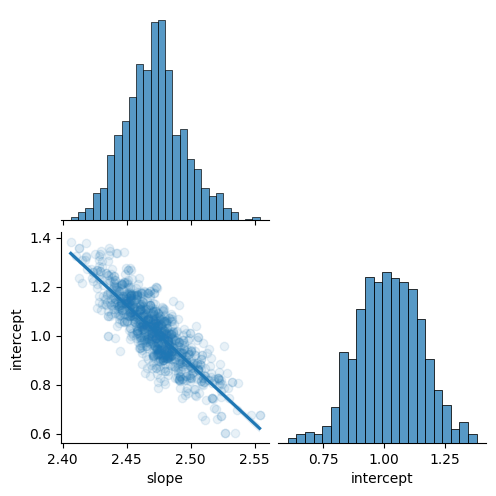

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_samples = pd.DataFrame({
    "slope": samples[:,0],
    "intercept": samples[:,1],
})

sns.pairplot(df_samples, corner=True, kind="reg",
             plot_kws={'scatter_kws': {'alpha': 0.1}})
plt.show()